# **Section:** Unbalance

In [1]:
import os
import itertools as it
import warnings
import time
import pickle

import numpy as np

import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

import joblib

import pathlib

from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import DataConversionWarning

from sklearn import metrics

import tqdm

from libs.container import Container
from libs.nearest import nearest
from libs.experiment import WithAnotherExperiment, roc, metrics
from libs.precstar import  prec_star

warnings.simplefilter("ignore", category=DataConversionWarning)

/home/jbcabral/miniconda2/envs/howfar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
PATH = pathlib.Path(os.path.abspath(os.path.dirname("")))

DATA_PATH = PATH / "_data"

COLUMNS_NO_FEATURES = ['id', 'tile', 'cnt', 'ra_k', 'dec_k', 'vs_type', 'vs_catalog', 'cls'] 

tiles = ["b234", "b360", "b278", "b261"]

In [3]:
plot_path = PATH / "plots" / "s_unbalance"
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

In [4]:
DATA_NAMES = {
    "s20k_scaled.pkl.bz2": 'Large',
    "s5k_scaled.pkl.bz2": 'Mid',
    "s2_5k_scaled.pkl.bz2": 'Small',
    "sO2O_scaled.pkl.bz2": 'One-to-One',
    "full_scaled.pkl.bz2": "Full"
}

In [5]:
%%time
datas = {}
for path in DATA_PATH.glob("*_scaled.pkl.bz2"):
    sample = pd.read_pickle(path)
    
    # the features
    X_columns = [c for c in sample.columns if c not in COLUMNS_NO_FEATURES]
    y_column = "cls"

    sample[X_columns] =  sample[X_columns].astype(np.float32)
    
    data_name = DATA_NAMES[path.name]
    datas[data_name] = Container({k: v for k, v in sample.groupby("tile") if k in tiles})

    del sample

CPU times: user 2min 20s, sys: 24.4 s, total: 2min 45s
Wall time: 1min 37s


In [6]:
REAL_SIZES = {k: len(v) for k, v in datas["Full"].items()}
REAL_SIZES

{'b234': 293013, 'b261': 555693, 'b278': 742153, 'b360': 939110}

## Run the classifiers with the selected parameters

In [7]:
RF_PARAMS = joblib.load("_cache/best_params.pkl.bz2")["rf"]
del RF_PARAMS["n_jobs"]
RF_PARAMS

{'criterion': 'entropy',
 'max_features': 'auto',
 'min_samples_split': 10,
 'n_estimators': 500}

In [8]:
def make_clf(k, df, X_columns):    
    X_train = df[X_columns].values
    y_train = df.cls.values

    clf = RandomForestClassifier(**RF_PARAMS)
    clf.fit(X_train, y_train)
    return k, clf


def get_clfs(data, X_columns):
    print("Creating classifiers with {} features...".format(len(X_columns)))
    with joblib.Parallel(n_jobs=-1) as jobs:
        clfs = jobs(
            joblib.delayed(make_clf)(k, d, X_columns)
            for k, d in sorted(tqdm.tqdm(data.items())))
    return Container(clfs)


def get_combs(data, X_columns):
    combs = []
    clfs = get_clfs(data, X_columns)
    for train_name, clf in clfs.items():
        for test_name in clfs.keys():
            if train_name != test_name:
                test_sample = data[test_name]
                comb = Container({
                    "idx": len(combs), 
                    "train_name": train_name, "clf": clf,  
                    "test_name": test_name, "test_sample": test_sample,
                    "X_columns": X_columns, "y_column": y_column})
                combs.append(comb)
    return combs


def execute_clf(idx, train_name, clf, test_name, test_sample, X_columns, y_column):
    
    X_test = test_sample[X_columns].values
    y_test = test_sample[y_column].values
    
    predictions = clf.predict(X_test)
    probabilities = clf.predict_proba(X_test)
    
    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, 1.-probabilities[:,0], pos_label=1)

    prec_rec_curve = metrics.precision_recall_curve(
        y_test, 1.- probabilities[:,0], pos_label=1)

    roc_auc = metrics.auc(fpr, tpr)
    
    result = Container({
        "idx": idx,
        "train_name": train_name,
        "test_name": test_name,
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'real_cls': y_test,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': metrics.confusion_matrix(y_test, predictions)})    
    return result

def train_and_run(data, X_columns):
    combs = get_combs(data, X_columns)
    print("Combinaciones: {}".format(len(combs)))
    
    print("Launching classifiers for {} features...".format(len(X_columns)))
    with joblib.Parallel(n_jobs=-1) as jobs:
        results = jobs(
            joblib.delayed(execute_clf)(**comb) for comb in tqdm.tqdm(combs))
    return results

In [9]:
%%time
o2o_results = train_and_run(datas["One-to-One"], X_columns)

100%|██████████| 4/4 [00:00<00:00, 7096.96it/s]

Creating classifiers with 62 features...



100%|██████████| 12/12 [00:00<00:00, 18648.26it/s]

Combinaciones: 12
Launching classifiers for 62 features...


CPU times: user 3.69 s, sys: 380 ms, total: 4.07 s
Wall time: 13.6 s


In [10]:
%%time
small_results = train_and_run(datas["Small"], X_columns)

100%|██████████| 4/4 [00:00<00:00, 7594.94it/s]

Creating classifiers with 62 features...



100%|██████████| 12/12 [00:00<00:00, 13903.77it/s]

Combinaciones: 12
Launching classifiers for 62 features...


CPU times: user 3.7 s, sys: 136 ms, total: 3.83 s
Wall time: 20.4 s


In [11]:
%%time
mid_results = train_and_run(datas["Mid"], X_columns)

100%|██████████| 4/4 [00:00<00:00, 8862.77it/s]

Creating classifiers with 62 features...



100%|██████████| 12/12 [00:00<00:00, 13350.57it/s]

Combinaciones: 12
Launching classifiers for 62 features...


CPU times: user 3.7 s, sys: 117 ms, total: 3.81 s
Wall time: 32.7 s


In [12]:
%%time
large_results = train_and_run(datas["Large"], X_columns)

100%|██████████| 4/4 [00:00<00:00, 9436.00it/s]

Creating classifiers with 62 features...



100%|██████████| 12/12 [00:00<00:00, 13382.52it/s]

Combinaciones: 12
Launching classifiers for 62 features...


CPU times: user 4.13 s, sys: 208 ms, total: 4.34 s
Wall time: 1min 41s


In [13]:
%%time
full_results = train_and_run(datas["Full"], X_columns)

100%|██████████| 4/4 [00:00<00:00, 16644.06it/s]

Creating classifiers with 62 features...



100%|██████████| 12/12 [00:00<00:00, 11222.22it/s]

Combinaciones: 12
Launching classifiers for 62 features...


CPU times: user 26 s, sys: 2.6 s, total: 28.6 s
Wall time: 1h 26min 6s


## Analysis

In [14]:
all_results = {
    "One-to-One": o2o_results,
    "Small": small_results,
    "Mid": mid_results,
    "Large": large_results,
    "Full": full_results
}

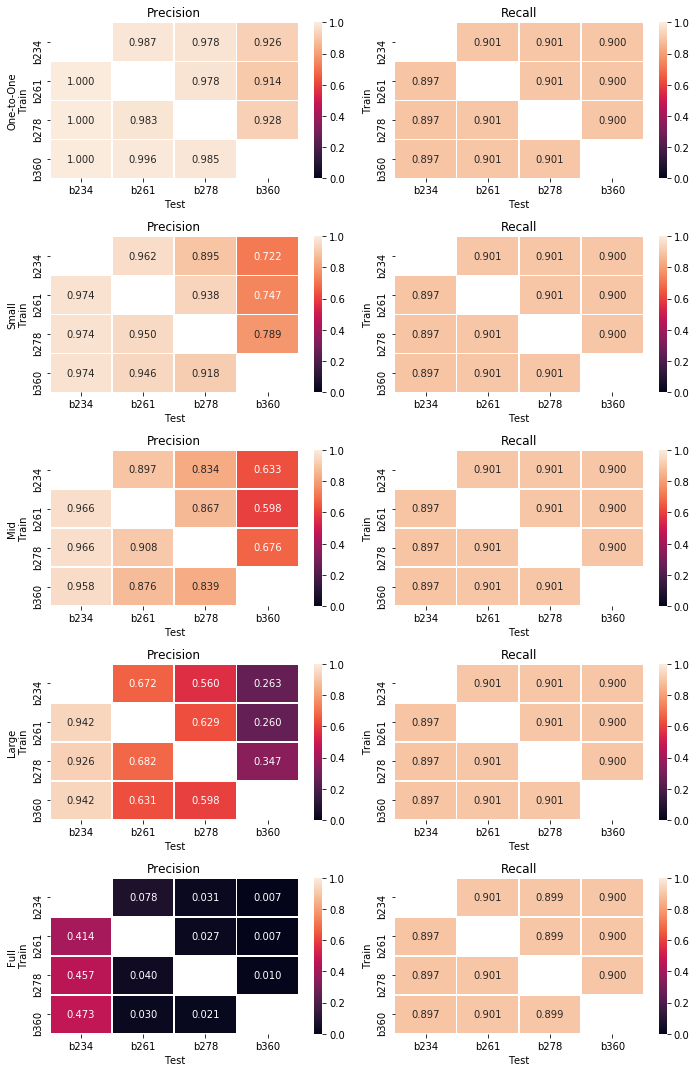

In [15]:
def as_df(data):
    rows, tiles = [], sorted(list(data.keys()))
    for rname in tiles:
        row = data[rname].copy()
        row.update({"Train": rname}) 
        rows.append(row)
    df = pd.DataFrame(rows)
    df = df.set_index("Train")[tiles]
    return df

def heatmap(ax, results, fp):
    cmap = sns.cm.rocket
    
    fix_recall, fix_precs = {}, {}
    for r in results:
        train_name, test_name = r["train_name"], r["test_name"]
        
        if train_name not in fix_recall:
            fix_recall[train_name] = {}
            fix_precs[train_name] = {}
            
        precs, recalls, probs = r.prec_rec_curve
        
        idx = nearest(recalls, fp)
        
        fix_recall[train_name][test_name] = recalls[idx]
        fix_precs[train_name][test_name] = precs[idx]
        
    fix_precs = as_df(fix_precs)
    fix_recall = as_df(fix_recall)
    
    sns.heatmap(fix_precs, annot=True, fmt='.3f',  linewidths=.5, ax=ax[0], cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax[0].set_xlabel("Test")
    ax[0].set_title(u"Precision".format(fp))
    
    sns.heatmap(fix_recall, annot=True, fmt='.3f', linewidths=.5, ax=ax[1], cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax[1].set_xlabel("Test")
    ax[1].set_title(u"Recall".format(fp))

fig, axes = plt.subplots(len(all_results), 2, figsize=(10, 3*len(all_results)))

for rname, axs in zip(all_results, axes):
    heatmap(axs, all_results[rname], 0.90)
    axs[0].set_ylabel(f"{rname}\n{axs[0].get_ylabel()}")
    
fig.tight_layout()
fig.savefig(plot_path / "section_unbalanced_samesize_prec_rec_heatmap.pdf")

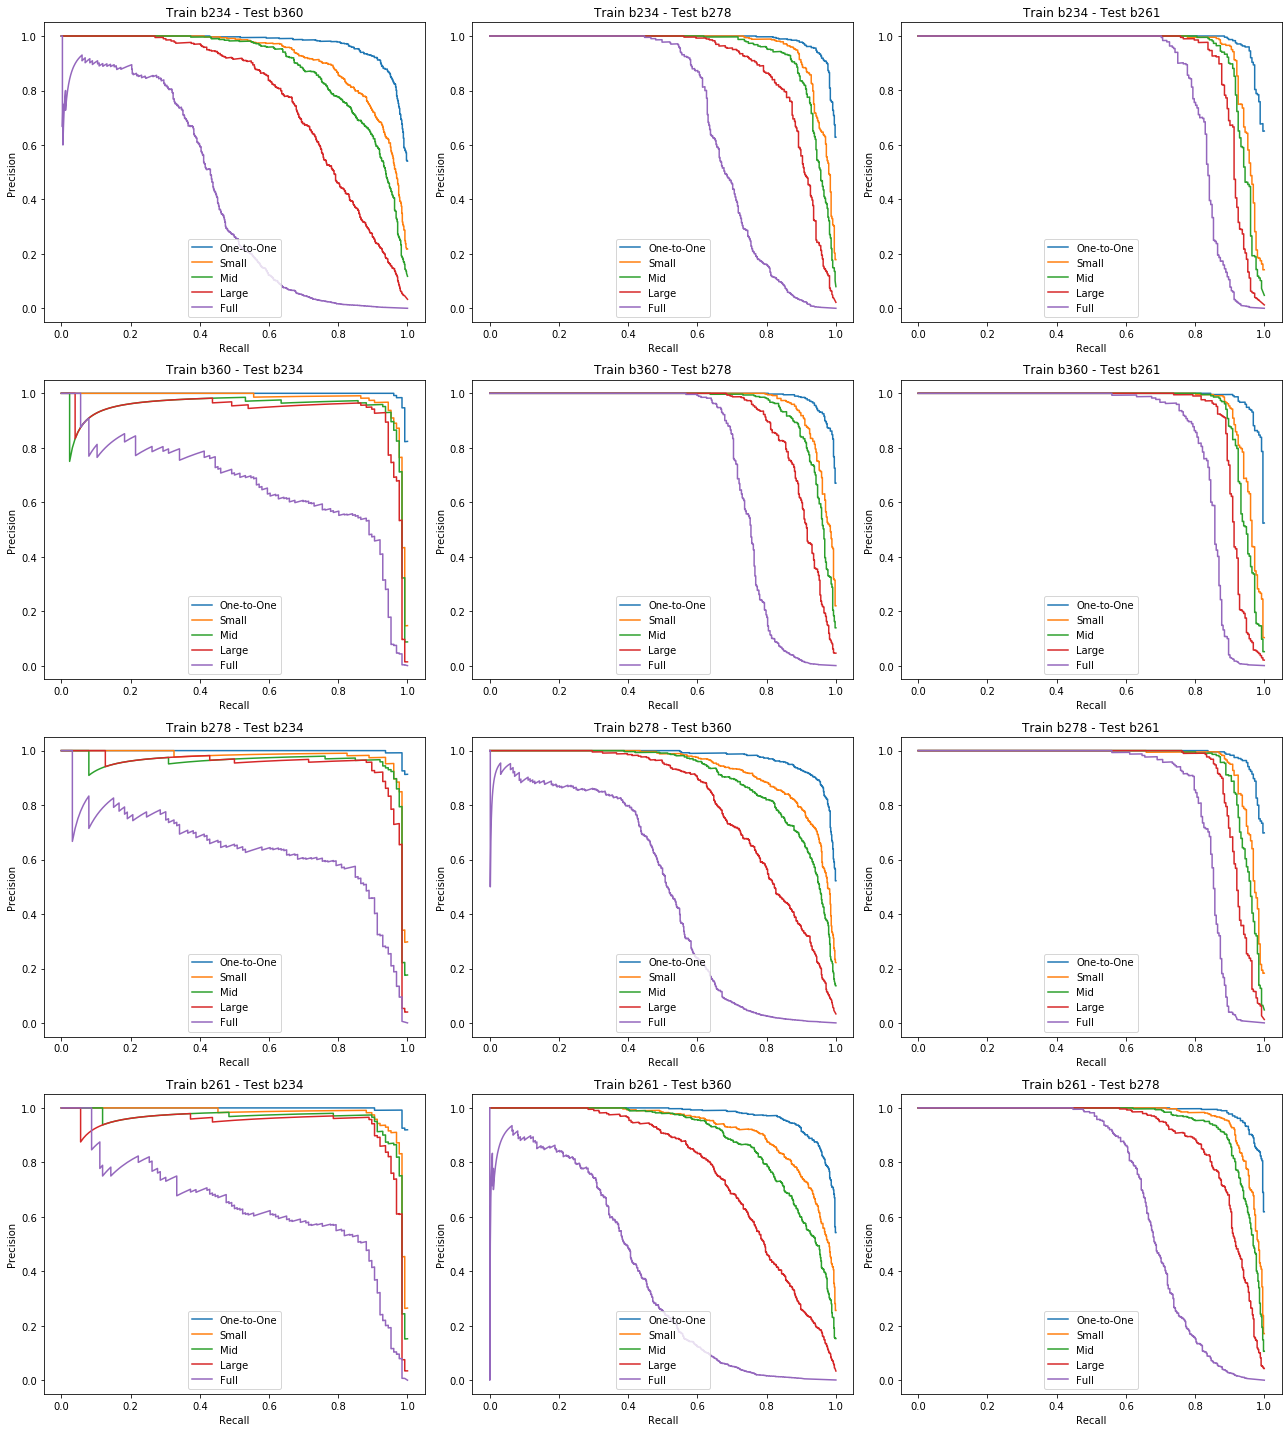

In [16]:
def plot_prec_roc_curve(ax, train_name, test_name, all_results):
    for rname, results in all_results.items():
        for r in results:
            if r.test_name == test_name and r.train_name == train_name:
                ax.plot(r.prec_rec_curve[1], r.prec_rec_curve[0], label=rname)
                break
    ax.set_title("Train {} - Test {}".format(train_name, test_name))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend(loc='lower center')

fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = it.chain(*axes)
for train_name in tiles:
    for test_name in tiles:
        if train_name == test_name:
            continue
        ax = next(axes)
        plot_prec_roc_curve(ax, train_name, test_name, all_results)
fig.tight_layout()
fig.savefig(plot_path / "section_unbalanced_samesize_prec_rec_curve.pdf")

## $P^*$

In [17]:
for results in all_results.values():
    for r  in results:
        pstar = prec_star(
            y_true=r.real_cls, probas_pred=1-r.probabilities[:,0],
            ss=len(r.real_cls), rs=REAL_SIZES[r.test_name], pos_label=1)
        
        r["prec_star_curve"] = pstar, r.prec_rec_curve[1], r.prec_rec_curve[2]

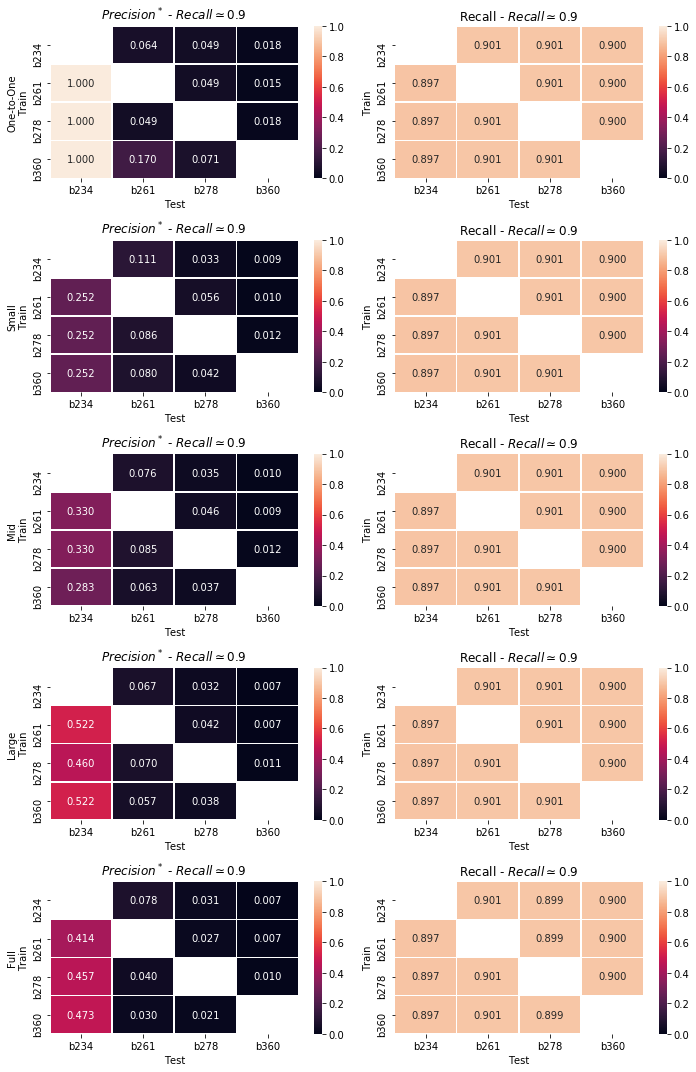

In [18]:
def pstar_heatmap(ax, results, fp):
    cmap = sns.cm.rocket
    
    fix_recall, fix_precs = {}, {}
    for r in results:
        train_name, test_name = r["train_name"], r["test_name"]
        
        if train_name not in fix_recall:
            fix_recall[train_name] = {}
            fix_precs[train_name] = {}
            
        precs, recalls, probs = r.prec_star_curve
        
        idx = nearest(recalls, fp)
        
        fix_recall[train_name][test_name] = recalls[idx]
        fix_precs[train_name][test_name] = precs[idx]
        
    fix_precs = as_df(fix_precs)
    fix_recall = as_df(fix_recall)
    
    sns.heatmap(fix_precs, annot=True, fmt='.3f',  linewidths=.5, ax=ax[0], cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax[0].set_xlabel("Test")
    ax[0].set_title(u"$Precision^*$ - $Recall\simeq{}$".format(fp))
    
    sns.heatmap(fix_recall, annot=True, fmt='.3f', linewidths=.5, ax=ax[1], cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax[1].set_xlabel("Test")
    ax[1].set_title(u"Recall - $Recall\simeq{}$".format(fp))

fig, axes = plt.subplots(len(all_results), 2, figsize=(10, 3*len(all_results)))

for rname, axs in zip(all_results, axes):
    pstar_heatmap(axs, all_results[rname], 0.90)
    axs[0].set_ylabel(f"{rname}\n{axs[0].get_ylabel()}")
    
fig.tight_layout()
fig.savefig(plot_path / "section_unbalanced_samesize_prec_star_heatmap.pdf")

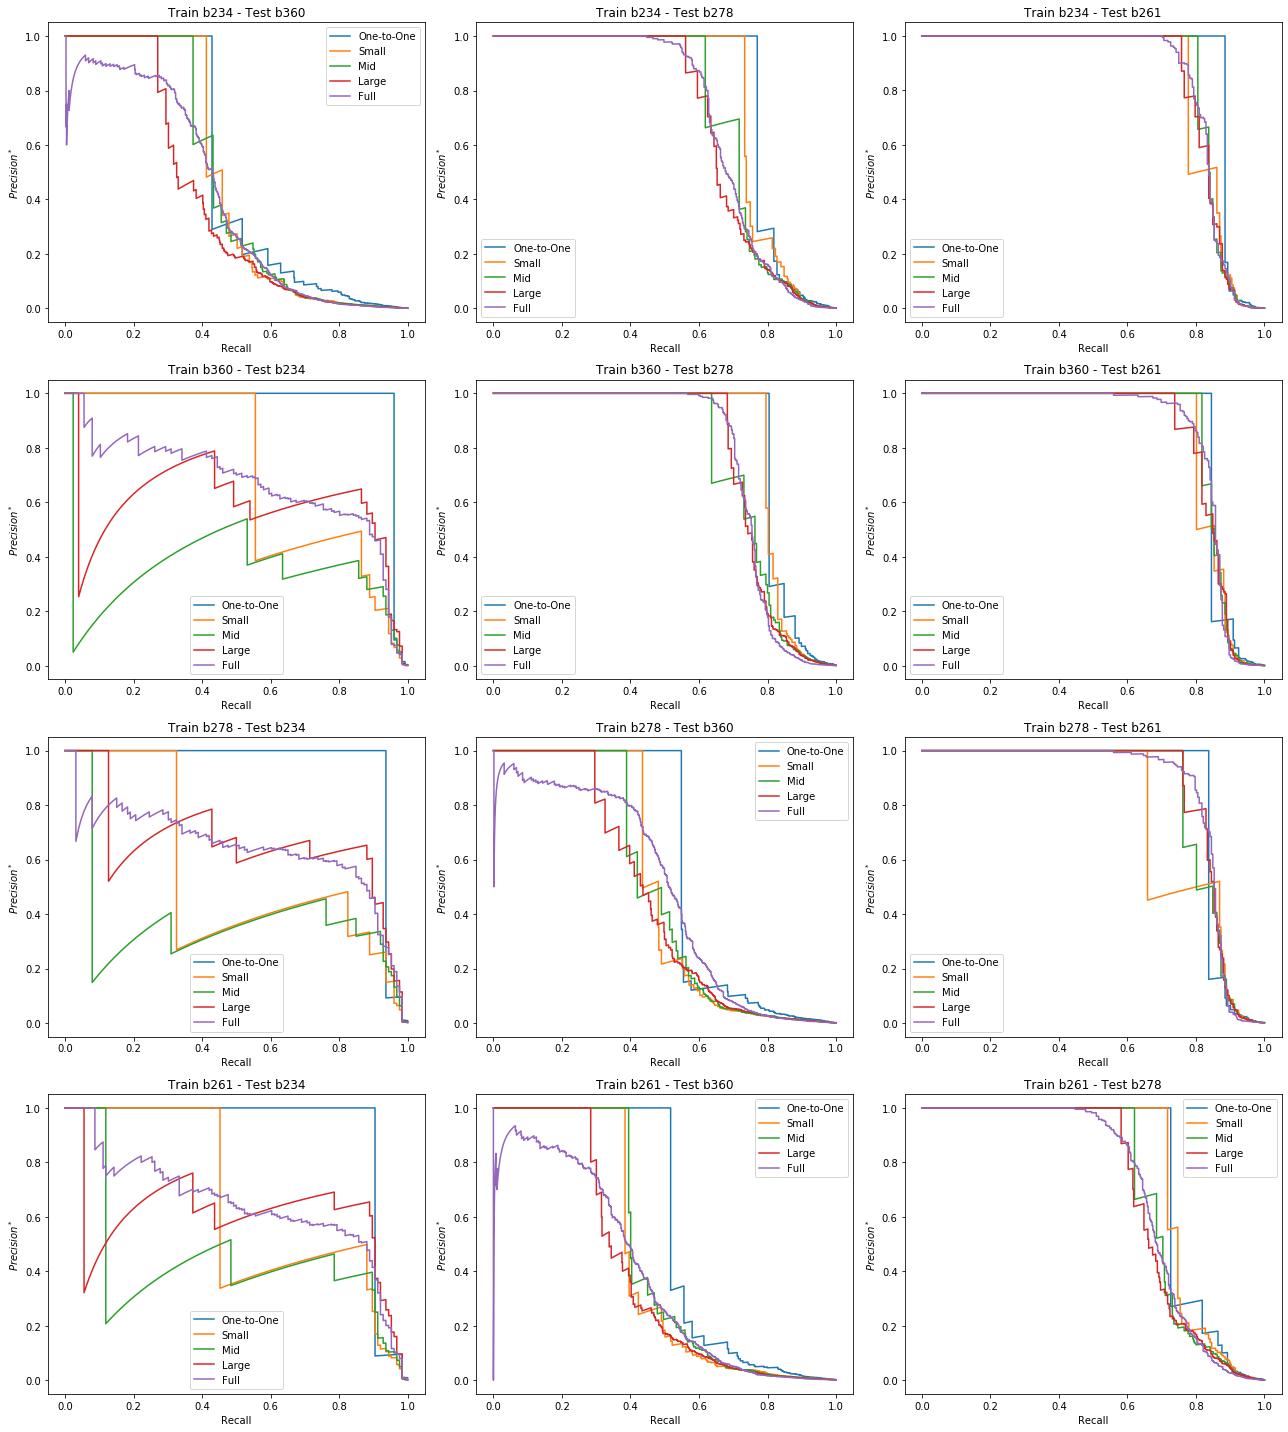

In [19]:
def plot_prec_star_curve(ax, train_name, test_name, all_results):
    for rname, results in all_results.items():
        for r in results:
            if r.test_name == test_name and r.train_name == train_name:
                ax.plot(r.prec_star_curve[1], r.prec_star_curve[0], label=rname)
                break
    ax.set_title("Train {} - Test {}".format(train_name, test_name))
    ax.set_xlabel("Recall")
    ax.set_ylabel("$Precision^*$")
    ax.legend(loc='best')

fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = it.chain(*axes)
for train_name in tiles:
    for test_name in tiles:
        if train_name == test_name:
            continue
        ax = next(axes)
        plot_prec_star_curve(ax, train_name, test_name, all_results)
fig.tight_layout()
fig.savefig(plot_path / "section_unbalanced_samesize_prec_star_curve.pdf")

In [20]:
import datetime
datetime.datetime.now()

datetime.datetime(2020, 1, 18, 22, 11, 33, 644206)